# Week 12: Positional encodings
The following is adapted from https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In order to retain positional information about words in a sequence, we need a way of encoding it. The most obvious way would be a simple index indicating the order of the words (tokens), but this would have to be normalised to the range (0, 1) in order to work well for neural networks, and this becomes an issue for sequences of variable lengths. Instead, we create a vector for each word which encodes the positional information according to the following formulas: 

$$P(k, 2i) = sin(\frac{k}{n^{\frac{2i}{d}}})$$
$$P(k, 2i + 1) = cos(\frac{k}{n^{\frac{2i}{d}}})$$

- $k$ is the index of the token in question
- $d$ is the desired dimension of the output, chosen to match the dimension of the word embeddings so they can be summed later
- $n$ is user defined, in the original paper they use $n=10,000$
- $i$ is used to create the sine then cosine pattern and is in the range $[0,\frac{d}{2}]$
- $P(k,j)$ is the function that maps a position $k$ from the input sequence to the index $(k, j)$ in the positional matrix.

The formula ensures that at each index the position is represented using an alternating series of sine and cosine waves.

For training an NLP model using positional encodings, the positional encoding is simply added to the vector embeddings at each index, an efficient and elegant way of including the information!

### Exercise 1: Understanding positional encodings

**1. Create the function `get_position_encoding` which takes the sequence length, $d$ and $n$ as inputs and outputs a matrix which represents $P$**

*Use numpy!*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
def get_positional_encodings(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = get_positional_encodings(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


**2. Now to understand what the encodings look like we will first plot the sinusoidals (columns of $P$) along with the points of each of the indices use the following function:**
- Try with sentences of different lengths

In [2]:
def plotSinusoid(y, plot_line=False, points_names=None, title=""):
    x = range(len(y))
    if plot_line:
        plt.plot(x, y,)
        if points_names is not None:
            for i, name in enumerate(points_names):
                plt.scatter(x[i], y[i], label=name)
    else:
        plt.scatter(x, y, marker="o")
    plt.title(title)

*We use a sequence length longer than the example sentence in order to make the plot look nicer*

In [3]:
example_sentence = "We walk when wearing what?"
P = get_positional_encodings(seq_len=len(example_sentence.split()) + 20, d=100, n=10_000)

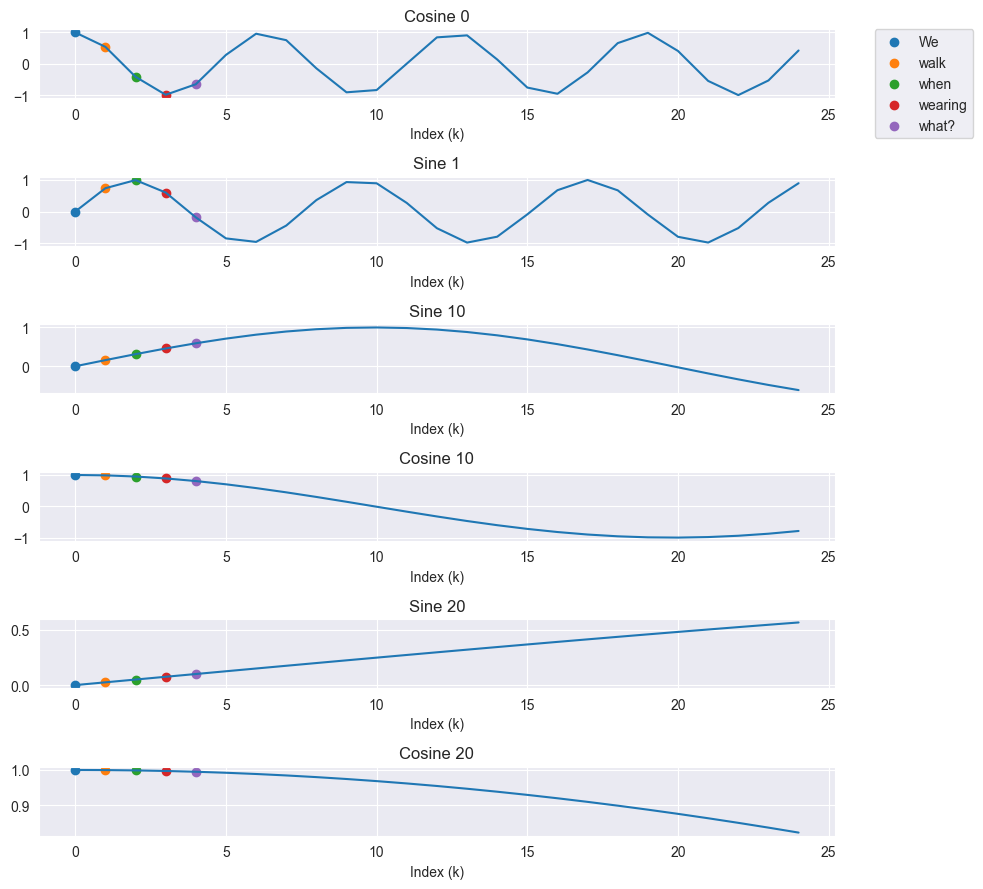

In [4]:
idxs = [1, 20, 40]
idxs.extend([el + 1 for el in  idxs])
idxs = sorted(idxs)
num_sinusoidals = len(idxs)
fig = plt.figure(figsize=(10, num_sinusoidals*1.5))    

for j, idx in enumerate(idxs):
    plt.subplot(num_sinusoidals, 1, j + 1)
    plotSinusoid(P[:, idx], plot_line=True, points_names=example_sentence.split())
    plt.title(f"{'Sine' if idx % 2 == 0 else 'Cosine'} {idx // 2}")
    plt.xlabel("Index (k)")
    if j == 0:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        
plt.tight_layout()
plt.show()

Now we will look at the actual positional encodings of each $k$:

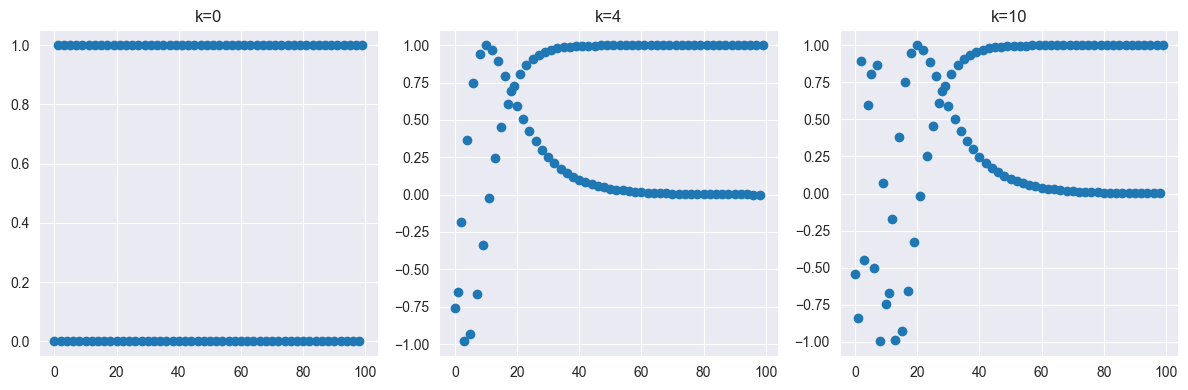

In [5]:
ks = [0, 4, 10, ]

fig = plt.figure(figsize=(len(ks)*4, 4))    
# Plot sine
for j, k in enumerate(ks):
    plt.subplot(1, len(ks), j + 1)
    plotSinusoid(P[k], title=f"k={k}")

plt.tight_layout()
plt.show()


And now let's inspect the entire matrix as a heatmap

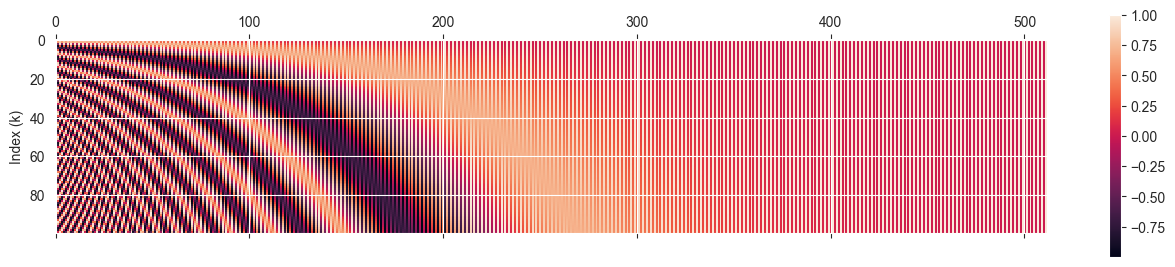

In [6]:
P = get_positional_encodings(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)
plt.ylabel("Index (k)")
plt.show()

### Exercise 2: Applying positional encodings to attention heads

In this exercise we will apply the positional encodings in the attention heads seen in week 11. We will also apply masked attention in order to illustrate how these two things make up a transformer. We will NOT be training our own transformer as this is an extremely time-consuming process if we want anything resembling decent results, both in pre-processing the text and in computation.

Positional encodings are applied to the word vectors BEFORE running attention and is done by simply adding the positional encoding vector to the word embeddings.


In [7]:
import torch
import torch.nn
import torch.nn.functional as F

**1. Re-write the `get_positional_encodings` so it uses pytorch instead of numpy in the function `get_positional_encodings_torch`**

*Nothing much changes*

In [8]:
def get_positional_encodings_torch(seq_len, d, n=10000):
    P = torch.zeros((seq_len, d))
    for k in range(seq_len):
        for i in torch.arange(int(d/2)):
            denominator = torch.pow(n, 2*i/d)
            P[k, 2*i] = torch.sin(k/denominator)
            P[k, 2*i+1] = torch.cos(k/denominator)
    return P

**2. Run the following cell, it is directly copied from week 11:**

In [9]:
def build_vocabulary(sentences, oov_token='OOV'):
    vocab = set()
    for sentence in sentences:
        words = sentence.lower().split()
        vocab.update(words)

    vocab.update([oov_token])

    # Wort vocab just to have it be nicer to look around    
    vocab = sorted(vocab)

    # Create dictionaries for word_to_index and index_to_word that given a word in the vocab returns the index or vice versa for in
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}

    # Define function for getting tokens from a sentence
    def tokens_to_indices(tokens):
        return [word_to_index[word] if word in word_to_index else word_to_index[oov_token] for word in tokens]
    
    return tokens_to_indices, word_to_index, index_to_word, vocab   

# Define completely random sentences to have a vocabulary
sentences = [
    "He turned himself into a pickle",
    "Sphinx of Black Quartz, Judge My Vow",
    "Skibidi dum dum yes yes",
    "The brain is rotting on the poles",
    "Release me from this flesh prison mortal fool",
    "I submit myself willingly to our artificial overlords",
    "One day the crude biomass that you call a temple will wither and you will beg my kind to save you",
    "For everything to be consummated for me to feel less alone I had only to wish that there be a large crowd of spectators the day of my execution and that they greet me with cries of hate"
]

# Create vocab based on sentences:
tokens_to_indices, word_to_index, index_to_word, vocab = build_vocabulary(sentences=sentences)

**3. Make a new attribute in the AttentionModule using the matrix returned by `get_positional_encodings_torch` and apply it to the word embeddings before running attention:**

- $\star$ Here we will not dynamically ensure that the matrix is always large enough to accommodate sentence of any length, implement a solution which ensures this.

In [10]:
class AttentionModule:
    def __init__(self, word_dim, Q_dim, K_dim, V_dim):
        # Create dummy embedding layer for word embeddings:
        # A torch embedding layer is just like a linear layer that only takes tensors of integers (technically torch.long values)
        self.word_embeddings = torch.nn.Embedding(len(vocab), word_dim)
        self.positional_encoding_matrix = get_positional_encodings_torch(seq_len=len(vocab), d=word_dim)
        # Define weight matrices for Queries, Keys and Values
        # Unlike the word embeddings, these need to work on torch tensors, so they are just linear layers, despite being used much like embeddings
        self.query_embeddings = torch.nn.Linear(word_dim, Q_dim)
        self.key_embeddings = torch.nn.Linear(word_dim, K_dim)
        self.value_embeddings = torch.nn.Linear(word_dim, V_dim)
        
        # Keep track of K_dim for scaling factors, otherwise handled by number of heads in multihead attention
        self.K_dim = K_dim
        
    def attention_from_tokens(self, token_indices, mask=False):
        # Transform to tensor to allow or use in word_embeddings:
        token_indices_tensor = torch.tensor(token_indices)
        embeddings = self.word_embeddings(token_indices_tensor)
        embeddings += self.positional_encoding_matrix[:embeddings.shape[0]]
        attention = F.softmax((self.query_embeddings(embeddings) @ self.key_embeddings(embeddings).T) / torch.sqrt(torch.tensor(self.K_dim)), dim=1)
        # Mask 
        if mask:
            seq_len = attention.size(-1)
            mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()  # Upper triangular mask
            attention = attention.masked_fill(mask, float('-inf'))
    
        representations = attention @ self.value_embeddings(embeddings)
        
        return attention, representations

In [11]:
def visualize_attention(attention_map, sentence_1: list[str], sentence_2: list[str], head: int=None):
    """
    Visualize the attention map between two sentences.
    
    Parameters:
        attention_map (numpy.ndarray): 2D array with attention weights. Shape: (len(sentence1), len(sentence2))
        sentence1 (list of str): The first sentence, tokenized into words.
        sentence2 (list of str): The second sentence, tokenized into words.
    """

    if head is not None:
        attention_map = attention_map[head]
    
    # Ensure the attention map dimensions match the sentences
    assert attention_map.shape == (len(sentence_1), len(sentence_2)), (
        "Attention map shape must match sentence lengths"
    )
    
    fig, ax = plt.subplots(figsize=(len(sentence_1), len(sentence_2)))
    cax = ax.matshow(attention_map, cmap='viridis', aspect='auto')
    
    # Add color bar
    plt.colorbar(cax, ax=ax, orientation='vertical')
    
    # Set up ticks and labels
    ax.set_xticks(np.arange(len(sentence_2)))
    ax.set_yticks(np.arange(len(sentence_1)))
    ax.set_xticklabels(sentence_2, rotation=90, fontsize=10)
    ax.set_yticklabels(sentence_1, fontsize=10)
    
    # Add labels for clarity
    ax.set_xlabel('Words in Sentence 2', fontsize=12)
    ax.set_ylabel('Words in Sentence 1', fontsize=12)
    plt.title('Attention Map', fontsize=14)
    
    if head is not None:
        plt.title(f'Attention Map for head {head}', fontsize=14)
        
    
    plt.tight_layout()
    plt.show()

In [12]:
new_sentence = " ".join(np.random.choice(vocab, 5))
# Add extra word just to showcase OOV tokens also being used
new_sentence += " factorio"
print("Random sentence is", new_sentence)
# Get tokens from the new sentence:
tokens = new_sentence.lower().split()
print(new_sentence, tokens)
token_indices = tokens_to_indices(tokens)

Random sentence is wish large willingly had i factorio
wish large willingly had i factorio ['wish', 'large', 'willingly', 'had', 'i', 'factorio']


wish large willingly had i factorio
None
Attention dimensionality is: torch.Size([6, 6])
After context layer (dotting with values, dimension is): torch.Size([6, 50])


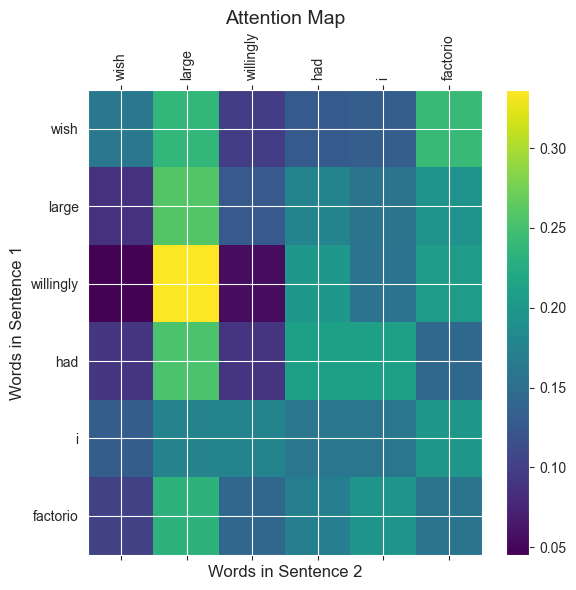

In [13]:
# Define dimensions of word embeddings, as well as Q, K and V matrices
word_dim = 50
Q_dim = 50
K_dim = 50
V_dim = 50

# Instantiate AttentionModule
attention_model = AttentionModule(word_dim, Q_dim, K_dim, V_dim)

# Print sentence we are getting attention for
print(print(new_sentence))

# Calculate the attention and context layer values
attention, representations = attention_model.attention_from_tokens(token_indices)

# Print and visualize
print("Attention dimensionality is:", attention.shape)
print("After context layer (dotting with values, dimension is):", representations.shape)

visualize_attention(attention.detach().numpy(), new_sentence.split(), new_sentence.split())

**4. Now apply masked attention to the module using a boolean value in the method `attention_from_tokens` that allows you to toggle it on and off. This is done in order to avoid leakage from future words when training a model to predict the next word (like most generative chatbots do)**

*On the above attention map, think about what part of it has to be masked out, and make sure the masking happens after attention is applied*



Attention dimensionality is: torch.Size([6, 6])
After context layer (dotting with values, dimension is): torch.Size([6, 50])


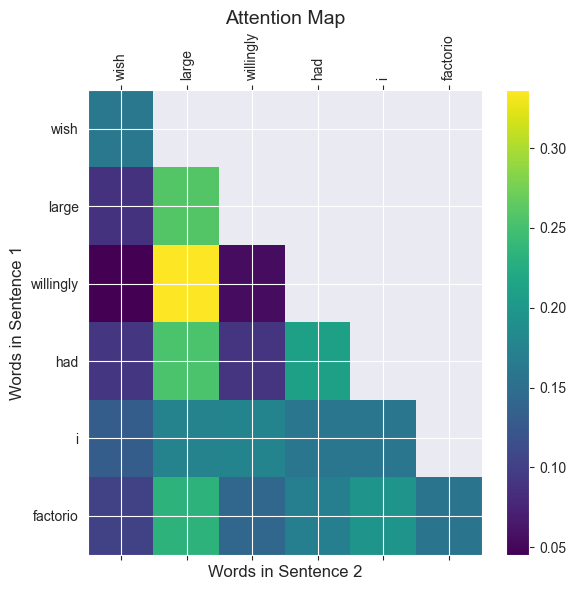

In [14]:
attention, representations = attention_model.attention_from_tokens(token_indices, mask=True)

# Print and visualize
print("Attention dimensionality is:", attention.shape)
print("After context layer (dotting with values, dimension is):", representations.shape)

visualize_attention(attention.detach().numpy(), new_sentence.split(), new_sentence.split())

**$\star \star \star$ 5. Apply masking and positional encodings to the MultiHeadAttentionModule from week 11**